c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


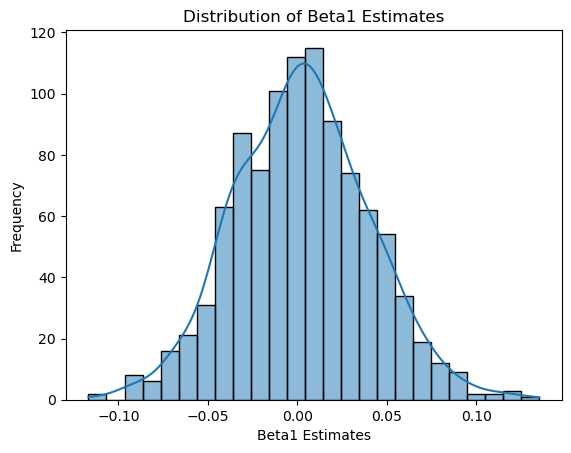

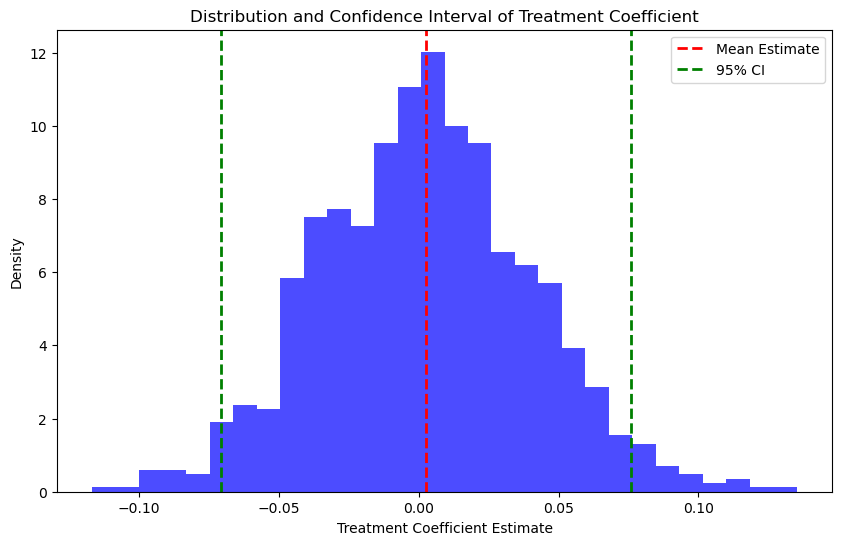

Number of times null hypothesis is rejected for : 130 out of 1000 simulations
Type 1 Error: 0.13
Bias for Coefficient of Treatment (True Value = 0): 0.002491737506329299
MSE for Coefficient of Treatment (True Value = 0): 0.00020311732406106864
Average RMSE for Coefficient of Treatment (True Value = 0): 0.014251923521443294
The confidence interval is (-0.07088867081585193, {0.07587214582851054})


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from Monte_Carlo_AR1 import (generate_staggered_law_ar1_data)

np.random.seed(42) 

beta1_estimates = []

reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
num_simulations = 1000
bias_values = []
squared_error_values = []
N = 50
T = 20
rho = 0.4
num_individuals = 500

true_beta1_value = 0
standard_error_values = []

bias_values = []



for _ in range(num_simulations):
    data = generate_staggered_law_ar1_data( N, T, rho, num_individuals)

    cps_agg = data.groupby(['state', 'time'])[['value', 'TREATMENT']].mean().reset_index()

    # One-hot encode STATEFIP and YEAR
    dummy_df_state = pd.get_dummies(cps_agg['state'], prefix='state', drop_first=True)
    dummy_df_year = pd.get_dummies(cps_agg['time'], prefix='time', drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    # Convert True and False to 1 and 0 in the specified columns
    boolean_columns = ['state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']

    cps_agg[boolean_columns] = cps_agg[boolean_columns].astype(int)

    data = cps_agg.copy()

    # Step 3: Perform the OLS regression
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['value'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit()

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / 1000

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()

# Calculate the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)
plt.figure(figsize=(10, 6))
plt.hist(beta1_estimates, bins=30, density=True, color='blue', alpha=0.7)
plt.axvline(np.mean(beta1_estimates), color='red', linestyle='dashed', linewidth=2, label='Mean Estimate')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Treatment Coefficient Estimate')
plt.ylabel('Density')
plt.title('Distribution and Confidence Interval of Treatment Coefficient')
plt.legend()
plt.show()


# Print the number of rejections
# Print the number of rejections
print(f"Number of times null hypothesis is rejected for : {reject_count} out of {num_individuals} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")
print(f"Average RMSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_rmse}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')




In [13]:
average_standard_error


0.028575055295698405

In [14]:
std_error_beta_distribution

0.03743898383784757